## **DM CAFFÈ**
### Análise das operações Maio 2022 a Maio 2023

In [1]:
# jupyter nbconvert --to html --no-input dmcafe_v02.ipynb

In [2]:
from IPython import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns; sns.set()
import datetime
import nbformat
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode (connected = True )
import plotly.graph_objs as go
import plotly.offline as py
from matplotlib.backends.backend_pdf import PdfPages
from fpdf import FPDF
pd.options.display.max_columns = None
pd.options.display.max_rows = None
import locale
import plotly.io as pio
from datetime import date
import calendar

from unidecode import unidecode

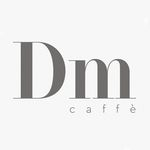

In [3]:
display.Image("/home/claudio/@DM_Cafe/logo/logo_dm_cafe.jpg",width=215)

In [4]:
# setar locale para português para que os dias da semana retornem em portugês no código abaixo.
locale.setlocale(locale.LC_ALL, 'pt_BR.utf-8')

from IPython.display import display, Markdown

# Importing each csv file and then joinning then, 
# as the files for other months are send by the client we can insert each one at the end of this code

df01 = pd.read_excel(r'/home/claudio/@DM_Cafe/dados_recebidos/2022_05.xlsx')
df02 = pd.read_excel(r'/home/claudio/@DM_Cafe/dados_recebidos/2022_06.xlsx' )
df03 = pd.read_excel(r'/home/claudio/@DM_Cafe/dados_recebidos/2022_07.xlsx')
df04 = pd.read_excel(r'/home/claudio/@DM_Cafe/dados_recebidos/2022_08.xlsx')
df05 = pd.read_excel(r'/home/claudio/@DM_Cafe/dados_recebidos/2022_09.xlsx')
df06 = pd.read_excel(r'/home/claudio/@DM_Cafe/dados_recebidos/2022_10.xlsx')
df07 = pd.read_excel(r'/home/claudio/@DM_Cafe/dados_recebidos/2022_11.xlsx')
df08 = pd.read_excel(r'/home/claudio/@DM_Cafe/dados_recebidos/2022_12.xlsx')
df09 = pd.read_excel(r'/home/claudio/@DM_Cafe/dados_recebidos/2023_01.xlsx')
df10 = pd.read_excel(r'/home/claudio/@DM_Cafe/dados_recebidos/2023_02.xlsx')
df11 = pd.read_excel(r'/home/claudio/@DM_Cafe/dados_recebidos/2023_03.xlsx')
df12 = pd.read_excel(r'/home/claudio/@DM_Cafe/dados_recebidos/2023_04.xlsx')
df13 = pd.read_excel(r'/home/claudio/@DM_Cafe/dados_recebidos/2023_05.xlsx')


In [5]:
# create the main dataframe
transactions = pd.concat([df01, 
df02, df03, df04, df05, df06, df07, df08, df09, df10, df11, df12, df13
                          ], ignore_index=True)
# remove the first row which is not required

transactions = transactions.iloc[1:]

# drop 'Total geral' and 'Total_geral.1' columns
transactions = transactions.drop(columns=['Total geral', 'Total geral.1'])

# creating an empty dataframe
transactions_long = pd.DataFrame()

# iterating through pairs of columns and stacking them
for i in range(2, len(transactions.columns), 2):
    df_temp = transactions.iloc[:, [0, 1, i, i+1]].copy()  # select date, product, value and quantity columns
    df_temp.columns = ['data', 'produto', 'valor', 'quantidade']
    df_temp['hora'] = transactions.columns[i][:5]  # add the hour column

    transactions_long = pd.concat([transactions_long, df_temp])

# drop all the rows that has  a 'NaN' value in both the 'valor' and 'quantidade' from the transactions_long dataframe
transactions_long = transactions_long.dropna(subset=['valor', 'quantidade'], how='all')

# drop all the rows that has  a 'NaN' value in produto from the transactions_long dataframe
transactions_long = transactions_long.dropna(subset=['produto'], how='all')

# drop the rows that have the string total in the 'date' column in the transactions_long datframe
transactions_long['data'] = transactions_long['data'].astype(str)
transactions_long = transactions_long[~transactions_long['data'].str.contains('total', case=False)]

# https://www.w3schools.com/python/pandas/ref_df_reset_index.asp
# Pandas DataFrame reset_index() Method
transactions_long.reset_index(drop= True, inplace=True)

# how to remove a piece of string R$ in the valor column?
transactions_long['valor'] = transactions_long['valor'].apply(lambda x: x.replace('R$ ', ''))

# change the decimal separator of the the variable "valor" from "," to "."
# https://cursos.alura.com.br/forum/topico-transformar-pontos-por-virgulas-dentro-de-um-dataframe-121090
transactions_long['valor'] = transactions_long['valor'].str.replace(",",".", regex=True)

# See Pandas 1.2.0 release notes:
# The default value of regex for Series.str.replace() will change from True to False in a future release. 
# In addition, single character regular expressions will not be treated as literal strings when regex=True is set (GH24804)
# I.e., use regular expressions explicitly now:

# Convert the valor column from string to float type
transactions_long['valor'] = transactions_long['valor'].astype(float)

# how to remove a piece of string '.00' in the quantidade column?
transactions_long['quantidade'] = transactions_long['quantidade'].apply(lambda x: x.replace('.00', ''))

# Convert the quantidade column from string to integer type
transactions_long['quantidade'] = np.int64(transactions_long['quantidade'])

# define a function to format currency values
def format_currency(value):
    return locale.currency(value, grouping=True)

# taking the valor unitário from the 'valor' column as the values provided were the valor unitario of the item multiplied by the quantidade
transactions_long['valor']= transactions_long['valor'] / transactions_long['quantidade']

# renaming the column valor para valor_unit
transactions_long.rename(columns = {'valor':'valor_unit'}, inplace = True)

# converting the data column from string to date_time
transactions_long['data']=pd.to_datetime(transactions_long['data'])

# insert a column name 'mes' 
transactions_long['mes'] = transactions_long.data.dt.month

# insert a column name 'dia_da_semana' 
transactions_long['dia_da_semana'] = [calendar.day_name[i.weekday()] for i in transactions_long['data']]

# insert a column name 'ano_mes' 
transactions_long['ano_mes'] = transactions_long['data'].dt.strftime('%Y-%m')

# em um string quero manter os primeiros dois digitos e descartar o restante
transactions_long['hora'] = transactions_long['hora'].str.slice(0, 2)

# Convert the hora column from string to integer type
transactions_long['hora'] = np.int64(transactions_long['hora'])

# Definindo a função time_of_day
def time_of_day(hora):
    """
    Determina se a  compra foi feita pela manhã, tarde ou noite.
    """
    
    if hora < 12:
        
        return 'manhã'
    
    elif hora < 18:
        
        return 'tarde'
    
    else:
        
        return 'noite'

# create the column 'periodo_do_dia'    
transactions_long['periodo_do_dia'] = transactions_long.hora.apply(time_of_day)

# Add a tipo_de_dia variable (FS= final de semana or DU=  dia útil)
transactions_long['tipo_de_dia'] = ['FS' if (i == 'domingo') | (i == 'sábado') else 'DU' for i in 
                                                                            transactions_long['dia_da_semana']]

# you can use the str.slice method to get the first 5 characters
# then str.replace to remove all non-digit characters
transactions_long['cod_produto'] = transactions_long['produto'].str.slice(0, 5).str.replace(r'\D', '', regex=True)

# TIREI O VALOR DO CÓDIGO DO PRODUTO DA COLUNA PRODUTO JÁ QUE ELE TEM UMA COLUNA SÓ PARA ESSE VALOR
transactions_long['produto'] = transactions_long['produto'].replace(r'^[^a-zA-Z]*', '', regex=True)


In [6]:

# Dados Faltantes

# FILTREI O DF TRANSACTIONS_LONG EM UM NOVO DATAFRAME PARA FICAR SÓ AS LINHAS CUJO VALOR UNITÁRIO ERA INEXISTENTE
dados_faltantes_01 = transactions_long.loc[pd.isna(transactions_long['valor_unit'])].copy()

#CONVERTI EM STRING A DATA
dados_faltantes_01['data']=(dados_faltantes_01['data']).astype(str)

# ORDENEI POR DATA
dados_faltantes_01 = dados_faltantes_01.sort_values(by='data')

# AGRUPEI OS DADOS FALTANTES POR PRODUTO
dados_faltantes_01_agrupados = dados_faltantes_01.groupby('produto').size().reset_index(name='counts')


In [7]:
%%capture

total_dados_faltantes = dados_faltantes_01_agrupados['produto'].value_counts().sum()
total_dados_faltantes

## Primeira observação quanto aos dados

In [8]:

# Gráfico 00

fig_00 = go.Figure(data=[go.Table(
    header=dict(values=list(['Produto', 'Ocorrências']),
                font=dict(color='white', size=14), # configurando a cor e tamanho da letra
                fill_color='gray',
                align='left'),
    cells=dict(values=[dados_faltantes_01_agrupados['produto'], dados_faltantes_01_agrupados['counts']],
               font=dict(color='black', size=12),
               fill_color='lightgray',
               align='left'))
])
fig_00.update_layout(
    title={
        'text': "Ocorrência dos registros que apresentam o valor zero na coluna quantidade",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

py.iplot(fig_00)


Identificamos que algumas entradas estão sem a informação de quantidade, tornando-as inadequadas para nossa análise. Esses registros, consequentemente, serão excluídos. Esta situação reforça a necessidade de um monitoramento rigoroso das comandas para evitar tais omissões. Infelizmente, 160 entradas tiveram que ser descartadas devido a este problema. Recomendamos práticas mais efetivas de registro para assegurar a qualidade dos dados futuros.

In [9]:
# Grafico 01
fig_01 = go.Figure(data=[go.Table(
    header=dict(values=list(['Data', 'Produto', 'hora', 'Quantidade']),
                font=dict(color='white', size=12), # configurando a cor e tamanho da letra
                fill_color='gray',
                align='left'),
    cells=dict(values=[dados_faltantes_01['data'], dados_faltantes_01['produto'], dados_faltantes_01['hora'], dados_faltantes_01['quantidade'] ],
              font=dict(color='black', size=12),
               fill_color='lightgray',
               align='left'))
])
fig_01.update_layout(
    title={
        'text': "Itens que apresentam o valor zero na coluna quantidade",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

py.iplot(fig_01)

Conforme podemos observar nas tabelas acima, os registros com quantidade não informada estão presentes em diversos meses da análise, abrangendo várias horas do dia e envolvendo um total de 56 produtos diferentes. Isso sugere que não estamos lidando com um problema isolado, mas sim com um problema sistêmico na coleta desses dados.

In [10]:
# exportando para excel o dataframe acima 
dados_faltantes_01.to_excel('/home/claudio/@DM_Cafe/documentos/quantidade_e_valor_zerados.xlsx')

In [11]:
# excluindo os registros que não possuem valor na coluna 'valor_unit' do Dataframe principal
transactions_long = transactions_long.loc[pd.notna(transactions_long['valor_unit'])].reset_index(drop = True).copy()

## Segunda observação quanto aos dados

Foram detectadas quantidades negativas nos dados gerados pelo sistema

In [12]:
# criando um DF com os ddados de quantidade negativos
transactions_long_negativos = transactions_long[transactions_long['quantidade'] < 0].copy()

#CONVERTI EM STRING A DATA
transactions_long_negativos['data']=(transactions_long_negativos['data']).astype(str)

# CRIANDO A COLUNA total_item, que é multiplicação da "quantidade" pelo "valor_unit"
transactions_long_negativos['total_item'] = (transactions_long_negativos['quantidade'])*(transactions_long_negativos['valor_unit'])

# Ordenei por data e hora
transactions_long_negativos = transactions_long_negativos.sort_values(by = ['data', 'hora'])

# E EXPORTANDO PARA UMA PLANILHA DO EXCEL
transactions_long_negativos.to_excel('/home/claudio/@DM_Cafe/documentos/quantidades_negativas.xlsx')

In [13]:
# Grafico 1,5
fig_1_5 = go.Figure(data=[go.Table(
    header=dict(values=list(['Data', 'Produto', 'hora', 'Quantidade', 'Valor Unitário']),
                font=dict(color='white', size=12), # configurando a cor e tamanho da letra
                fill_color='gray',
                align='left'),
    cells=dict(values=[transactions_long_negativos['data'], transactions_long_negativos['produto'], transactions_long_negativos['hora'], transactions_long_negativos['quantidade'],
                       transactions_long_negativos['valor_unit']],
              font=dict(color='black', size=12),
               fill_color='lightgray',
               align='left'))
])
fig_1_5.update_layout(
    title={
        'text': "Itens que apresentam valores negativos na coluna quantidade",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

py.iplot(fig_1_5)

In [14]:
# Agrupei os valor por período para basear uma hipotese

transactions_long_negativos_grouped = transactions_long_negativos.groupby(by = 'periodo_do_dia').size().reset_index(name = 'counts')


# Define a color scheme for each category
color_dict_periodo = {"manhã": 'lightgreen', "tarde": 'darkorange', 'noite': 'royalblue'}

# Map category to color
transactions_long_negativos_grouped['color'] = transactions_long_negativos_grouped['periodo_do_dia'].map(color_dict_periodo)


In [15]:
# GRÁFICO 1,75

fig_pie_1_75 = go.Figure(data=[go.Pie(labels=transactions_long_negativos_grouped['periodo_do_dia'], values=transactions_long_negativos_grouped['counts'], pull=[0, 0.2, 0, 0, 0, 0,0], 
                                   marker=dict(colors=transactions_long_negativos_grouped['color']), textinfo='label+percent')])

fig_pie_1_75.layout = dict(title="Distribuição dos itens com quantidade negativas  <br><sup>(Maio 2022 - Maio 2023)</sup>", showlegend=True,
  paper_bgcolor='lightgray',  # Set the plot background color
   legend=dict(font=dict(size=14), tracegroupgap=7,  # Set the gap between legend color squares
        bordercolor='black',  # Set the border color around the legend color squares
        borderwidth=1  # Set the border width around the legend color squares
)  # Set the font size in the legend 
)

fig_pie_1_75.update_traces(hoverinfo='label+percent', textfont_size=11,
                  )


py.iplot(fig_pie_1_75)

In [16]:
# só para dar espaço

Com base nas observações e no gráfico acima, podemos notar que os itens com quantidades negativas estão distribuídos ao longo de vários meses e abrangem diversos produtos. No entanto, é possível perceber que essas ocorrências são mais frequentes durante os horários da tarde e, principalmente, à noite, representando quase 60% do total.

Esses padrões nos levam à hipótese de que esses itens foram solicitados, mas não estavam mais disponíveis no estoque, resultando no cancelamento da venda. Essa situação poderia ser evitada para aprimorar a experiência do cliente e, principalmente, para evitar perdas de receita, uma vez que esses clientes já estavam dispostos a consumir os produtos.

É importante que o estabelecimento tome medidas para garantir a disponibilidade dos produtos e evitar a ocorrência dessas situações, visando oferecer uma experiência positiva aos clientes e maximizar as oportunidades de vendas.

Porém iremos excluir esses itens da nossa análise a partir desse ponto. Utilizamos tecnicas para eliminar os valores negativos de quanttidade, fazendo a compensação com os valores dos registros que tem o mesmo produto e no mesmo dia.

In [17]:
# criando a variável soma dos negativos
soma_negativos = transactions_long_negativos['total_item'].sum()
soma_negativos = float(soma_negativos)
soma_negativos_formatado = format_currency(soma_negativos)
text_0C = f'### O valor total do itens com quantidades negativas foi de: {soma_negativos_formatado}'

# display as Markdown
display(Markdown(text_0C))

### O valor total do itens com quantidades negativas foi de: -R$ 3.718,90

In [18]:
transactions_long = transactions_long.sort_values(by=['data', 'produto', 'hora'], ascending=[True, True, False]).reset_index(drop=True)


In [19]:
# Copying the main dataframe to a new DF.
fusion_transactions = transactions_long.copy()

In [20]:
# With this code, we keep track of the previous data and produto values. 
# When we encounter a row where either of these values differs from the previous row, we reset debt to 0 and update prev_data and prev_produto.
# This way, we isolate the debt for each data/produto combination.

fusion_transactions.reset_index(drop=True, inplace=True)

debt = 0
prev_data = None
prev_produto = None

for i in range(len(fusion_transactions)):
    # reset debt if data or produto changes
    if (fusion_transactions.loc[i, 'data'] != prev_data) or (fusion_transactions.loc[i, 'produto'] != prev_produto):
        debt = 0
        prev_data = fusion_transactions.loc[i, 'data']
        prev_produto = fusion_transactions.loc[i, 'produto']

    if fusion_transactions.loc[i, 'quantidade'] < 0:
        debt += abs(fusion_transactions.loc[i, 'quantidade'])
        fusion_transactions.loc[i, 'quantidade'] = 0
    elif debt > 0:
        if fusion_transactions.loc[i, 'quantidade'] >= debt:
            fusion_transactions.loc[i, 'quantidade'] -= debt
            debt = 0
        else:
            debt -= fusion_transactions.loc[i, 'quantidade']
            fusion_transactions.loc[i, 'quantidade'] = 0


In [21]:
# SÓ PARA TESTAR SE O CÓDIGO ACIMA DEU CERT0 exportando para uma planilha 
fusion_transactions_negativos_post_cleaning = fusion_transactions.loc[~fusion_transactions['quantidade'] > 0].copy()
fusion_transactions_negativos_post_cleaning.to_excel('/home/claudio/@DM_Cafe/documentos/dataframe_quantidade_negativa_pos_limpeza.xlsx')

In [22]:
# CRIANDO O DATAFRAME PRINCIPAL LIMPO
transactions_long_clean= fusion_transactions.loc[fusion_transactions['quantidade'] > 0].copy()

In [23]:
# CRIANDO A COLUNA total_item, que é multiplicação da "quantidade" pelo "valor_unit"
transactions_long_clean['total_item'] = (transactions_long_clean['quantidade'])*(transactions_long_clean['valor_unit'])

In [24]:
# EXPORTANDO O DF PRINCIPAL
transactions_long_clean.to_excel('/home/claudio/@DM_Cafe/documentos/dataframe_limpo.xlsx')

In [25]:
# só para dar espaços

# **<center>Análise exploratória dos Dados (AED)</center>**

A limpeza de dados foi realizada como primeira etapa, seguida da Análise Exploratória de Dados (AED) como segunda etapa, onde os dados foram estruturados e ilustrados visualmente.

In [26]:
faturamento = pd.Series(transactions_long_clean['total_item'].sum())

# define a function to format currency values
def format_currency(value):
    return locale.currency(value, grouping=True)

## Observações preliminares

In [27]:
# Find Unique Values of each item sold in the Column "produto"
# https://www.statology.org/pandas-unique-values-in-column/
# Pandas: get first 10 elements of a series
top_produtos_df = transactions_long_clean.groupby('produto').sum('quantidade').copy()

# print (top_produtos[:20])
### Converting a Series to a dataframe and changing the namee of the column
top_produtos_df = top_produtos_df.sort_values(by='quantidade', ascending= False).reset_index()


# renomear as colunas produto e index
#top_produtos_df.rename(columns = {'produto':'quantidade', 'index':'produto'}, inplace = True)

Abaixo segue uma tabela com o ranking dos produtos mais vendidos, logo depois observamos algumas métricas.

In [28]:
# Gráfico 02

fig_top_produtos = go.Figure(data=[go.Table(
    header=dict(values=list(['Produto', 'Quantidade', 'Total Vendas']),
                font=dict(color='white', size=14), # configurando a cor e tamanho da letra
                fill_color='gray',
                align='left'),
    cells=dict(values=[top_produtos_df['produto'], top_produtos_df['quantidade'], top_produtos_df['total_item']
                       .apply(lambda x: 'R$ ' + locale.format_string('%.2f', x, grouping = True)) 
                         ],
               font=dict(color='black', size=12),
               fill_color='lightgray',
               align='left'))
])


fig_top_produtos.update_layout(
    title={
        'text': "Produtos mais vendidos - (Maio 2022 - Maio 2023)",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

py.iplot(fig_top_produtos)

### Exclusão de itens com informações não identificáveis

Os itens "adicional", "porção extra" e "evento individual" foram excluídos da análise devido à falta de informações identificáveis e sua insignificante contribuição para as vendas totais (destacados abaixo). Isso permite uma análise mais precisa e focada nos elementos relevantes, auxiliando na tomada de decisões estratégicas para impulsionar o crescimento do negócio. 

In [29]:
# Criei um array para fazer a filtragem dos valores desse itens
array00 = ['ADICIONAL', 'PORCAO EXTRA', 'EVENTO INDIVIDUAL', 'PORÇÃO EXTRA']

# Fiz a filtragem dos valores do array no DF principal
transactions_nd = transactions_long_clean.loc[transactions_long_clean['produto'].isin(array00)].copy()

# fiz o agrupamento dos valores por produto
transactions_nd_grouped = (transactions_nd.groupby('produto').sum('quantidade')).copy().reset_index()

# Gráfico 03

fig_nd_grouped = go.Figure(data=[go.Table(
    header=dict(values=list(['Produto', 'Quantidade', 'Total Vendido']),
                font=dict(color='white', size=14), # configurando a cor e tamanho da letra
                fill_color='gray',
                align='left'),
    cells=dict(values=[transactions_nd_grouped['produto'], transactions_nd_grouped['quantidade'],transactions_nd_grouped['total_item'].apply(lambda x: 'R$ ' + locale.format_string('%.2f', x, True))  ],
               font=dict(color='black', size=12),
               fill_color='lightgray',
               align='left'))
])


fig_nd_grouped.update_layout(
    title={
        'text': "Produtos com iformações não identificáveis - (Maio 2022 - Maio 2023)",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    width=800,  # Set the width of the chart page
    height=275  # Set the height of the chart page
        )

py.iplot(fig_nd_grouped)

In [30]:
# RETIREI OS DADOS REFERENTES AO INTENS 'ADICIONAL', 'PORCAO EXTRA', 'EVENTO INDIVIDUAL'
transactions_long_filtrado= transactions_long_clean.loc[~transactions_long_clean['produto'].isin(array00)].copy()

In [31]:
faturamento = float(faturamento)
faturamento_formatado = format_currency(faturamento)
text_0B =f'### O faturamento total do periodo foi de: {faturamento_formatado}'

# display as Markdown
display(Markdown(text_0B))

### O faturamento total do periodo foi de: R$ 189.701,60

In [32]:
## Get unique names in the "produto" column using Series.unique() 
## https://sparkbyexamples.com/pandas/pandas-count-unique-values-in-column/
num_itens_vend = transactions_long_filtrado.produto.unique().size

text_0A = f'### O número de diferentes itens vendido pelo estabelecimento no período foi: {num_itens_vend}'

# display as Markdown
display(Markdown(text_0A))

### O número de diferentes itens vendido pelo estabelecimento no período foi: 101

In [33]:
# achando a média do numero de itens vendidos por dia
grouped_by_date = pd.DataFrame(transactions_long_filtrado.groupby(by='data')[['quantidade', 'total_item']].sum(numeric_only=True)).reset_index()
formatted_media_itens = grouped_by_date.quantidade.mean().round(2)
formatted_media_itens = locale.format_string('%.2f', formatted_media_itens)
text00 = f'### O número médio de itens vendidos por dia foi: {formatted_media_itens}'


# display as Markdown
display(Markdown(text00))

### O número médio de itens vendidos por dia foi: 47,26

In [34]:
# ...and how that varies by time of day by revenue

vendas_por_periodo = transactions_long_filtrado.groupby(by=['data', 'periodo_do_dia'])['total_item'].sum().round (decimals=2).copy()


vendas_por_periodo = vendas_por_periodo.to_frame().reset_index()


vendas_por_periodo_grouped_media = vendas_por_periodo.groupby(by='periodo_do_dia').mean(numeric_only=True).round(2).reset_index()


vendas_por_periodo_grouped_media = vendas_por_periodo_grouped_media.sort_values(by='total_item', ascending=False)


vendas_por_periodo_grouped_media = vendas_por_periodo_grouped_media.rename(columns={'periodo_do_dia':'Período do dia', 'total_item': 'Faturamento Médio'})

soma_vendas = vendas_por_periodo_grouped_media.sum(numeric_only=True).values[0]
formatted_soma_vendas = 'R$ ' + locale.format_string('%.2f',(soma_vendas), True)
text01 = f'### O valor médio de vendas por dia é: {formatted_soma_vendas}'

# display as Markdown
display(Markdown(text01))

### O valor médio de vendas por dia é: R$ 638,19

In [35]:
# ...and how that varies by time of day by itens sold

itens_por_periodo = transactions_long_filtrado.groupby(by=['data', 'periodo_do_dia'])['quantidade'].sum().round (decimals=2).copy()
itens_por_periodo = itens_por_periodo.to_frame().reset_index()

itens_por_periodo_grouped_media = itens_por_periodo.groupby(by='periodo_do_dia').mean(numeric_only=True).round(2).reset_index()
itens_por_periodo_grouped_media = itens_por_periodo_grouped_media.sort_values(by='quantidade', ascending=False)

itens_por_periodo_grouped_media = itens_por_periodo_grouped_media.rename(columns={'periodo_do_dia':'Período do dia', 'quantidade': 'Média de Itens'})


 #### A fim de fornecer uma base sólida para as análises subsequentes, é importante estabelecer as convenções que serão adotadas. As seguintes convenções foram consideradas:
    - turno da manhã, das 06:00hs as 11:59hs;
    - turno da tarde, das 12:00hs as 17:59hs;
    - turno da noite, das 18:00hs as 23:59hs;

In [36]:
# Gráfico 04

fig_nd_grouped_media = go.Figure(data=[go.Table(
    header=dict(values=list(itens_por_periodo_grouped_media.columns),
                font=dict(color='white', size=14), # configurando a cor e tamanho da letra
                fill_color='gray',
                align='left'),
    cells=dict(values=[itens_por_periodo_grouped_media['Período do dia'], itens_por_periodo_grouped_media['Média de Itens'] ],
               font=dict(color='black', size=12),
               fill_color='lightgray',
               align='left'))
])


fig_nd_grouped_media.update_layout(
    title={
        'text': "Médias de itens vendidos por período - (Maio 2022 - Maio 2023)",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        width=800,  # Set the width of the chart page
    height=275  # Set the height of the chart page
)
py.iplot(fig_nd_grouped_media)

In [37]:
# Gráfico 05

fig_nd_vendas_grouped_media = go.Figure(data=[go.Table(
    header=dict(values=list(vendas_por_periodo_grouped_media.columns),
                font=dict(color='white', size=14), # configurando a cor e tamanho da letra
                fill_color='gray',
                align='left'),
    cells=dict(values=[vendas_por_periodo_grouped_media['Período do dia'], vendas_por_periodo_grouped_media['Faturamento Médio'].apply(lambda x: 'R$ ' + locale.format_string('%.2f', x, True)) ],
               font=dict(color='black', size=12),
               fill_color='lightgray',
               align='left'))
])


fig_nd_vendas_grouped_media.update_layout(
    title={
        'text': "Faturamento médio por período - (Maio 2022 - Maio 2023)",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        width=800,  # Set the width of the chart page
    height=275  # Set the height of the chart page
        )

py.iplot(fig_nd_vendas_grouped_media)

O turno da tarde apresenta o melhor faturamento, seguido pelo turno da manhã, enquanto o da noite é o menos lucrativo. Surge a dúvida se a decisão mais acertada seria eliminar o turno da noite em vez do turno da manhã, como foi feito pelos gestores. Outros fatores, como disponibilidade de funcionários e demanda, podem ter influenciado a escolha. No entanto, é importante considerar as consequências para o negócio, especialmente se o turno da manhã for movimentado ou atender a um público específico.

In [38]:
# Sales trend by date
# https://www.youtube.com/watch?v=Xjm7fOw6gjY
# use reset index for transforming the data in a variable not a index

grouped_by_date = pd.DataFrame(transactions_long_filtrado.groupby(by=['data','dia_da_semana'])[['quantidade', 'total_item']].sum().reset_index())

# This code creates a new column in the DataFrame, data_formatada, which contains the formatted dates in Portuguese.

def format_date_portuguese(date):
    month = date.strftime('%b')
    day = date.strftime('%d')
    year = date.strftime('%Y')
    return f'{day} {month.capitalize()}, {year}'

# Apply the function to each date in your DataFrame
grouped_by_date['data_formatada'] = grouped_by_date['data'].apply(format_date_portuguese)

# Create the column total_item formatted for Brazilian Real (R$)
grouped_by_date['total_item_formatada']= grouped_by_date['total_item'].apply(lambda x: locale.currency(x, grouping=True))

In [39]:
# Gráifco 06

venda_itens = px.line(grouped_by_date, x = 'data', y = 'quantidade', hover_data=["quantidade", "dia_da_semana" , 'data_formatada'],
                 title = 'Itens vendidos por dia - Maio 2022 a Maio 2023<br />', labels= {'quantidade' : 'Quantidade','data': 'Data'},
)
                 

# update line color
venda_itens.update_traces(line_color='black')

# update backgournd
venda_itens.update_layout(
    title={'text': 'Itens vendidos por dia - Maio 2022 a Maio 2023<br />', 'x': 0.5},
    plot_bgcolor='lightgray', 
    xaxis =dict(mirror=True,
    ticks='outside', showline=True, linecolor='black', gridcolor='white'),
    yaxis =dict(mirror=True, ticks='outside', showline=True, linecolor='black', gridcolor='white'
)
)
# Date tickvals
x_tickvals = pd.to_datetime(['2022-05-02', '2022-07-01', '2022-09-01', '2022-11-01', '2023-01-01', '2023-03-01', '2023-05-01'])

# Convert dates to desired format
x_ticktext = [date.strftime('%b %y').capitalize() for date in x_tickvals]

venda_itens.update_xaxes(
    tickvals=x_tickvals,
    ticktext=x_ticktext
)

venda_itens.update_traces(hovertemplate='Data: %{customdata[1]}<br>Dia da semana: %{customdata[0]}<br>Quantidade: %{y}<extra></extra>')


py.iplot(venda_itens)

In [40]:
# só para dar espaço

In [41]:
# Gráifco 07C


venda_valor = px.line(grouped_by_date, x='data', y='total_item', hover_data=["dia_da_semana", "total_item_formatada", 'data_formatada'],
                 title = 'Faturamento por dia - Maio 2022 a Maio 2023<br />', labels= {'total_item' : 'Faturamento','data': 'Data'})

# update line color
venda_valor.update_traces(line_color='royalblue')

# update backgournd
venda_valor.update_layout(
    title={'text': 'Faturamento por dia - Maio 2022 a Maio 2023<br />', 'x': 0.5},
    plot_bgcolor='lightgray', 
    xaxis =dict(mirror=True,ticks='outside', showline=True, linecolor='black', gridcolor='white'
   ),
    yaxis =dict(mirror=True, ticks='outside', showline=True, linecolor='black', gridcolor='white',
             )  
)

# Date tickvals
x_tickvals = pd.to_datetime(['2022-05-02', '2022-07-01', '2022-09-01', '2022-11-01', '2023-01-01', '2023-03-01', '2023-05-01'])

# Convert dates to desired format
x_ticktext = [date.strftime('%b %y').capitalize() for date in x_tickvals]

venda_valor.update_xaxes(
    tickvals=x_tickvals,
    ticktext=x_ticktext
)


# Number of ticks you want to display
num_ticks = 8 # For 0, 200, 400, 600, 800, 1000, 1200, 1400

# Create a linear space from min to max of 'total_item'
tickvals = np.linspace(0, 1400, num_ticks)

# Convert tick values to Brazilian Real format
ticktext = ['R${:,.2f}'.format(val).replace(",", "x").replace(".", ",").replace("x", ".") for val in tickvals]

venda_valor.update_yaxes(
    tickvals=tickvals,
    ticktext=ticktext
)

# os valores do customdata se referem aos valores da hooverdata na primeira linha desse bloco de código
venda_valor.update_traces(hovertemplate='Data: %{customdata[2]}<br>Dia da semana: %{customdata[0]}<br>Faturamento: %{customdata[1]}<extra></extra>')

venda_valor.show()


Ao analisarmos as vendas, tanto no gráfico de itens vendidos quanto no de faturamento, percebemos que eles são praticamente iguais. Isso ocorre porque os valores dos itens vendidos não diferem muito entre si. No entanto, é evidente que há uma variação considerável nos resultados, com alguns dias registrando vendas próximas a 250 reais e outros alcançando valores acima dos mil reais.

Um dado importante que podemos constatar é que não há um dia específico que se destaque em termos de vendas. No entanto, em relação aos dias com vendas mais baixas, fica claro que a maioria deles ocorreu aos sábados. Essa observação nos leva a refletir sobre o funcionamento do estabelecimento nesse dia específico.

Além disso, outra observação que podemos fazer é que a variação nas vendas entre os dias diminuiu consideravelmente desde o final de março. Isso pode indicar que houve alguma alteração nas estratégias de vendas, mudanças na demanda dos clientes ou qualquer outro fator que tenha contribuído para essa redução na variação.

In [42]:
# só para dar espaço

In [43]:
# só para dar espaço

## Evolução do faturamento

In [44]:
# criamos o daaframe fatura_grouped_by_month, utilizando o parametro .copy

fatura_grouped_by_month = transactions_long_filtrado.groupby(['ano_mes']).agg({"total_item":sum,'quantidade':sum}).reset_index().copy()

#This code snippet groups the transactions DataFrame by the 'month' column and then aggregates the 'quantidade' field using the sum #function. Let's break it down line by line:

#grouped_by_month = transactions.groupby('month'): This line of code uses the groupby method of the pandas DataFrame to group the #rows of transactions based on the unique values in the 'month' column. This creates a GroupBy object, which is a special pandas #object that can be used for aggregation and transformation tasks on the grouped data.

#grouped_by_month.agg({'quantidade': 'sum'}): This line of code uses the agg method of the GroupBy object, which allows you to #apply aggregation functions on one or more columns of the grouped data. The agg method takes a dictionary as input, where the keys #are the column names to be aggregated, and the values are the aggregation functions to be applied. In this case, the dictionary
#{'quantidade': 'sum'} tells pandas to aggregate the 'quantidade' column using the 'sum' function. This will compute the sum of the #'quantidade' values for each group of rows that share the same value in the 'month' column.

#As a result, the code snippet creates a new DataFrame, grouped_by_month, which contains the sum of the 'quantidade' field for each #unique value in the 'month' column.

In [45]:
# change the value in the first row of this column: fatura_grouped_by_month['ano mês'] as it is the first day of operations
fatura_grouped_by_month.loc[0, 'ano_mes'] = '2022-05-02'


In [46]:
fatura_grouped_by_month['faturamento_mes']= fatura_grouped_by_month['total_item'].apply(lambda x: locale.currency(x, grouping=True)).copy()

# chatgpt sugested code 
# https://stackabuse.com/format-number-as-currency-string-in-python/

In [47]:
# convert ano_mes to datetime format if it's in string format
fatura_grouped_by_month['ano_mes'] = pd.to_datetime(fatura_grouped_by_month['ano_mes'])

# creating a dictionary to map the English month names to Portuguese
months_portuguese = {1: 'Jan', 2: 'Fev', 3: 'Mar',
                     4: 'Abr', 5: 'Mai', 6: 'Jun', 
                     7: 'Jul', 8: 'Ago', 9: 'Set', 
                     10: 'Out', 11: 'Nov', 12: 'Dez'}

# creating a new column 'mes_ano_portuguese' with the Portuguese month names and year
fatura_grouped_by_month['mes_ano_portuguese'] = fatura_grouped_by_month['ano_mes'].dt.month.map(months_portuguese) + ' ' + fatura_grouped_by_month['ano_mes'].dt.year.astype(str)



In [48]:
# convert a column in a pandas dataframe to a series to create the values for the x axis

ano_mes_series = fatura_grouped_by_month['ano_mes']

In [49]:
# Gráfico 08_B

fig_08_B_go = go.Figure([go.Bar (x=fatura_grouped_by_month['ano_mes'], y=fatura_grouped_by_month['total_item'],customdata=fatura_grouped_by_month['quantidade'],
            marker_color="black", text= fatura_grouped_by_month['faturamento_mes'], hovertemplate ='Quant. itens:<br> %{customdata}<extra></extra>'
        )])

fig_08_B_go.add_annotation(x = '2022-10', y = 20000, text = 'R$ 20.000,00 <br />Faturamento de equilibrio', showarrow= True, arrowhead= 2)

fig_08_B_go.add_shape(
            type="line",
            x0=fatura_grouped_by_month['ano_mes'].min(),
            x1=fatura_grouped_by_month['ano_mes'].max(),
            y0=20000,
            y1=20000,
            line=dict(
                color="Green",
                width=3
            ),
)

# Date tickvals
x_tickvals = pd.to_datetime(ano_mes_series)

# Convert dates to desired format
x_ticktext = [date.strftime('%b %y').capitalize() for date in x_tickvals]

fig_08_B_go.update_xaxes(
    tickvals=x_tickvals,
    ticktext=x_ticktext
)
# add the R$ symbol and thounsand delimiter
# https://stackoverflow.com/questions/58140143/add-currency-symbol-in-the-y-axis-scale-using-plotly-method-in-python
fig_08_B_go.update_layout(plot_bgcolor='white', 
                        yaxis_tickprefix = 'R$', yaxis_tickformat = ',.2f', title = 'Faturamento Mensal<br />Maio 2022 a Maio 2023', 
                        xaxis = dict(title = ''),
                        yaxis = dict(visible= False, title = 'Faturamento'))


 
   # xaxis =dict(mirror=True, ticks='outside', showline=True, linecolor='black', gridcolor='lightgray'),
    # yaxis =dict(visible= False, mirror=True, ticks='outside', showline=True, linecolor='black', gridcolor='lightcyan')



fig_08_B_go.show()

A análise do gráfico revela que, ao longo dos meses considerados, o faturamento não atingiu o ponto de equilíbrio. Além disso, observa-se uma queda acentuada no faturamento a partir de fevereiro de 2023, possivelmente relacionada à exclusão do turno da manhã. Embora o retorno desse turno tenha ocorrido em maio de 2023, não foi o bastante para restaurar o faturamento aos níveis anteriores. Esses dados sugerem a necessidade de uma análise mais aprofundada das causas dessa queda e de estratégias adicionais para alcançar a estabilidade financeira desejada.

In [50]:
# só para dar espaço

# Analisando a venda de itens

Agora iremos analisar mais detalhadamente a distribuição na venda de cada item proporcionalmente as vendas totais e por categorias

In [51]:
# exportei a lista de produtos para categorizar
top_produtos_df.to_excel('/home/claudio/@DM_Cafe/documentos/lista_produtos.xlsx')

In [52]:
# Eu criei o DataFrame "categorias" importando uma planilha CSV previamente elaborada, para tanto utilizando o Chat GPT, e categorizei a lista dos produtos vendidos pelo estabelecimento.
# Create the df_categories

df_categorias = pd.read_csv(r'/home/claudio/@DM_Cafe/documentos/lista_produtos_categorizados.CSV', encoding="ISO-8859-1", sep = ';')
df_categorias = df_categorias.dropna().copy()
df_categorias = df_categorias.reset_index(drop = True)
df_categorias = df_categorias.applymap(lambda s: s.upper() if type(s) == str else s)
df_categorias = df_categorias.applymap(lambda x: unidecode(str(x)))
df_categorias['produto'] = df_categorias['produto'].replace('CROISSANT QUEIJO TOMATE OREGANO', 'CROISSANT QUEIJO TOMATE OREGAN')

In [53]:
# RETIREI OS DADOS REFERENTES AO INTENS 'ADICIONAL', 'PORCAO EXTRA', 'EVENTO INDIVIDUAL'
array01 = ['ADICIONAL', 'PORCAO EXTRA', 'EVENTO INDIVIDUAL', 'PRODUTO', 'PORÇÃO EXTRA']

df_categorias= df_categorias.loc[~df_categorias['produto'].isin(array01)].copy()

df_categorias = df_categorias.reset_index(drop = True)

In [54]:
# criando o DF grouped_transactions
grouped_transactions = transactions_long_filtrado.groupby('produto')[['total_item', 'quantidade']].sum().reset_index().copy()
grouped_transactions = grouped_transactions.sort_values(by = 'total_item', ascending= False).reset_index(drop= True)

In [55]:
# Calculate the total value across all rows
total_value_itens = grouped_transactions['total_item'].sum()

# Create a new column that calculates the percentage
grouped_transactions['percentual_faturamento'] = ((grouped_transactions['total_item']/ total_value_itens) * 100).round(2)

grouped_transactions['valor_unit_med'] = (grouped_transactions['total_item']/grouped_transactions['quantidade']).round(2)

In [56]:
# adicionar as categorias ao DF grouped_transactions
df_grouped_categorized = grouped_transactions.merge(df_categorias, how = 'outer', on = 'produto' )

In [57]:
### Tabela 09

fig_top_produtos = go.Figure(data=[go.Table(
    header=dict(values=list(['Produto', 'Quantidade', 'Percentual Faturamento', 'Categoria', 'Valor Unid. médio']),
                font=dict(color='white', size=12), # configurando a cor e tamanho da letra
                fill_color='black',
                align='left'),
    cells=dict(values=[df_grouped_categorized['produto'], df_grouped_categorized['quantidade'], df_grouped_categorized['percentual_faturamento'], df_grouped_categorized['categoria'], df_grouped_categorized['valor_unit_med']],
               font=dict(color='white', size=12),
               fill_color='gray',
               align='left'))
])


fig_top_produtos.update_layout(
    title={
        'text': "Produtos mais vendidos - (Maio 2022 a Maio 2023)",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

py.iplot(fig_top_produtos)

In [58]:
# GRÁFICO 10

# Creating a plot to show the TOP itens sold by month (Maio 2022 - Maio 2023)

item_threshold = 241

# ordenar em ordem de quantidade
df_grouped_categorized = df_grouped_categorized.sort_values(by = 'quantidade', ascending= False)

colors_todo = ['black',] * len(df_grouped_categorized)
# Destacar comidas
colors_todo[0] = 'green' 
colors_todo[2] =  'green' 
colors_todo[16] = 'green'



trace_df_grouped_categorized = go.Bar(
    x = df_grouped_categorized['produto'],
    y = df_grouped_categorized['quantidade'][(df_grouped_categorized['quantidade']) > item_threshold],
            #x=item_frequencies_2023[item_frequencies_2023 > item_threshold_2023].index,
            # y=item_frequencies_2023[item_frequencies_2023 > item_threshold_2023].values,
         text=df_grouped_categorized['quantidade'],
            visible=True,
            marker_color=colors_todo,
            name='Todo periodo'
    )



data_df_grouped_categorized = [trace_df_grouped_categorized]


layout_df_grouped_categorized = dict(title='Vendas por item - Maio 2022 - Maio 2023 <br><sup></sup>', showlegend=False)

# to change the background color

layout_df_grouped_categorized.update(
    plot_bgcolor='lightgray', 
    xaxis =dict(mirror=True, ticks='outside', showline=True, linecolor='black', gridcolor='lightgray'),
    yaxis =dict(visible= False, mirror=True, ticks='outside', showline=True, linecolor='black', gridcolor='lightcyan')
)
fig_df_grouped_categorized = dict(data=data_df_grouped_categorized, layout=layout_df_grouped_categorized)
py.iplot(fig_df_grouped_categorized)

O gráfico analisado revela que a venda de bebidas à base de café no estabelecimento é liderada pelo Capuccino Italiano, seguido pelo expresso. No entanto, nenhum outro item dessa categoria está presente nos dez mais vendidos, indicando a falta de destaque para essas bebidas. Para se diferenciar e atrair clientes em busca de qualidade a um preço acessível, é recomendado dar maior ênfase às bebidas à base de café, posicionando a cafeteria como um local especializado nesse tipo de bebida.

Embora as bebidas à base de café não ocupem posição de destaque nas vendas, é importante notar que os itens mais vendidos são comidas que combinam bem com essas bebidas. Aproveitar essa oportunidade e criar combos atrativos, que incluam tanto bebidas à base de café quanto os produtos alimentícios populares, pode impulsionar as vendas. Dessa forma, os clientes terão a chance de desfrutar de uma experiência completa, combinando uma bebida saborosa com uma opção alimentar agradável.

Ao analisar os dados, podemos constatar que a soma das quantidades dos alimentos presentes entre os 15 itens mais vendidos resulta em um total de 4252 unidades. Por outro lado, a soma das quantidades vendidas do Capuccino Italiano e do expresso é de 2328 unidades, revelando uma diferença de 1924 unidades. Essa diferença representa 1924 oportunidades perdidas de vender um item à base de café em conjunto com um alimento, o que poderia impulsionar o faturamento e proporcionar uma experiência mais completa aos clientes.

In [59]:
# so para dar espaço

In [60]:
# so para dar espaço

In [61]:
# retirar quaisquer espaços da coluna 'categoria' para que possamos utlizar o mapeamento
df_grouped_categorized['categoria'] = df_grouped_categorized['categoria'].str.strip()

# ordenando por percentual do faturamento em ordem decrescente
df_grouped_categorized = df_grouped_categorized.sort_values(by = 'percentual_faturamento', ascending= False)

# Define a color scheme for each category
color_dict = {"CAFES": 'green', "DOCES": 'darkorange', 'SALGADOS': 'gold', 'BEBIDAS': 'royalblue', 'DIVERSOS':'brown'}

# Map category to color
df_grouped_categorized['color'] = df_grouped_categorized['categoria'].map(color_dict)


In [62]:
# GRÁFICO 11

fig_pie_11 = go.Figure(data=[go.Pie(labels=df_grouped_categorized['categoria'], values=df_grouped_categorized['percentual_faturamento'], pull=[0, 0.2, 0, 0, 0, 0,0], 
                                   marker=dict(colors=df_grouped_categorized['color']), textinfo='label+percent')])

fig_pie_11.layout = dict(title="Percentual do Faturamento por Categoria  <br><sup>(Maio 2022 - Maio 2023)</sup>", showlegend=True,
  paper_bgcolor='lightgray',  # Set the plot background color
   legend=dict(font=dict(size=14), tracegroupgap=7,  # Set the gap between legend color squares
        bordercolor='black',  # Set the border color around the legend color squares
        borderwidth=1  # Set the border width around the legend color squares
)  # Set the font size in the legend 
)

fig_pie_11.update_traces(hoverinfo='label+percent', textfont_size=11,
                  )


py.iplot(fig_pie_11)

In [110]:
df_diversos = (df_categorias.loc[df_categorias['categoria'] == 'DIVERSOS']).set_index('categoria')
diversos_list = df_diversos['produto'].tolist()
print('Os itens da categoria diversos são:',', '.join(str(item) for item in diversos_list))

Os itens da categoria diversos são: DM BLEND MOIDO 250G, COMBO PAO DE QUEIJO CAPP ITALI, COMBO CROISSANT CAPP ITALIANO, CANECA DM, COMBO MINI CROISSANT COM ADICI, FILTRO V60 01, V60 01


In [111]:
# Só para dar espaço

Com base nos dados fornecidos, podemos tirar algumas conclusões:

Faturamento por categoria: As bebidas à base de café representam 32,6% do faturamento total, o que indica que já são uma parte significativa dos negócios.

Potencial de crescimento: Embora as bebidas à base de café sejam uma parte importante do faturamento, os salgados e doces juntos representam a maior fatia, com 54,7%. Isso indica que há espaço para expandir a venda de bebidas à base de café e capturar uma parcela maior do mercado.

Diversificação: As bebidas representam apenas 11,2% do faturamento, enquanto os diversos têm percentuais ainda menores. Isso sugere que há uma oportunidade de diversificar seu cardápio de bebidas, oferecendo uma variedade mais ampla para atrair diferentes tipos de clientes.

Sugestões para melhorar a venda de bebidas à base de café:

Promoções e destaque: Crie promoções específicas para as bebidas à base de café, oferecendo descontos ou combos especiais. Além disso, destaque essas bebidas no menu e nos materiais de marketing para chamar a atenção dos clientes.

Desenvolvimento de novas receitas: Inove no seu cardápio de bebidas à base de café, desenvolvendo receitas criativas e exclusivas. Experimente combinações de sabores, ingredientes e apresentações diferentes para oferecer opções únicas aos clientes.

Treinamento da equipe: Certifique-se de que sua equipe esteja bem treinada para preparar e recomendar as bebidas à base de café. Eles devem ser capazes de explicar os diferentes tipos de bebidas, ingredientes e processos de preparação aos clientes, garantindo uma experiência positiva.

## Os itens mais vendidos por período do dia

In [113]:
# Grafico 12

# Find the frequency of each item purchased and by time of day

item_frequencies_all = transactions_long_filtrado.produto.value_counts()
item_frequencies_morning = transactions_long_filtrado[transactions_long_filtrado.periodo_do_dia == 'manhã'].produto.value_counts()
item_frequencies_afternoon = transactions_long_filtrado[transactions_long_filtrado.periodo_do_dia == 'tarde'].produto.value_counts()
item_frequencies_evening = transactions_long_filtrado[transactions_long_filtrado.periodo_do_dia == 'noite'].produto.value_counts()

# Creating a plot with the TOP itens sold per period of the day

# Plot the frequency of purchase for each item

# https://community.plotly.com/t/errors-accessing-plotly-api/33271
# ok, so I found a solution to my problem - when I let my program run through, the error message produced is:
#chart_studio.exceptions.PlotlyRequestError: Authentication credentials were not provided.
#I Googled this error and there were suggestions to run plotly in offline mode by replacing:



# Solving the problem of the 'plotly' online library with chart_studio
# https://plotly.com/python/getting-started-with-chart-studio/

##  Now I'm using Plotly Express (px) and Graphics Objects (go) # 13/03/2023

button_layer_1_height = 1.12
button_layer_2_height = 1.065

item_threshold_all = 290
item_threshold_manha = 40
item_threshold_tarde = 115
item_threshold_noite = 30


# https://plotly.com/python/bar-charts/#basic-bar-charts-with-plotlygraphobjects
# Customizing Individual Bar Colors

# Cores das barras todo dia
colors1 = ['black',] * len(transactions_long_filtrado)
# destacar venda de bebidas a base de café
colors1[0]= 'green'
colors1[2] = 'green'

# Cores das barras manhã
colors2 = ['black',] * len(transactions_long_filtrado)
# destacar venda de bebidas a base de café
colors2[0]= 'green'
colors2[3] = 'green'

# Cores das barras tarde
colors3 = ['black',] * len(transactions_long_filtrado)
# destacar venda de bebidas a base de café
colors3[0]= 'green'
colors3[2]= 'green'
colors3[17]= 'green'
colors3[18]= 'green'

# Cores das barras noite
colors4 = ['black',] * len(transactions_long_filtrado)
# destacar venda de bebidas a base de café
colors4[0]= 'green'
colors4[6]= 'green'
colors4[14]= 'green'




# https://plotly.com/python/bar-charts/#basic-bar-charts-with-plotlygraphobjects - customizando as barras
trace_all = go.Bar(
            x=item_frequencies_all[item_frequencies_all > item_threshold_all].index,
            y=item_frequencies_all[item_frequencies_all > item_threshold_all].values,text=item_frequencies_all,
            visible=True,
            marker_color=colors1,
            name='Dia Inteiro'
    )

trace_morning = go.Bar(
            x=item_frequencies_morning[item_frequencies_morning > item_threshold_manha].index,
            y=item_frequencies_morning[item_frequencies_morning > item_threshold_manha].values,text=item_frequencies_morning,
            visible=False,
            marker_color= colors2,
            name='Manhã'
    )

trace_afternoon = go.Bar(
            x=item_frequencies_afternoon[item_frequencies_afternoon > item_threshold_tarde].index,
            y=item_frequencies_afternoon[item_frequencies_afternoon > item_threshold_tarde].values,text=item_frequencies_afternoon,
            visible=False,
            marker_color=colors3,
            name='Tarde'
    )

trace_evening = go.Bar(
            x=item_frequencies_evening[item_frequencies_evening > item_threshold_noite].index,
            y=item_frequencies_evening[item_frequencies_evening > item_threshold_noite].values,text=item_frequencies_evening,
            visible=False,
            marker_color= colors4,
            name='Noite'
    )



data12= [trace_all, trace_morning, trace_afternoon, trace_evening]

# Inserir um update _layout para colocar um subtitle
# https://stackoverflow.com/questions/58166002/how-to-add-caption-subtitle-using-plotly-method-in-python

updatemenus = list([
    
    dict(
         buttons=list([   
            dict(label = 'Dia inteiro',
                 method = 'update',
                 args = [{'visible': [True, False, False, False]},
                         {'title': 'Os mais vendidos por período (Maio 22 - Maio 23) <br><sup>Dia inteiro - produtos com mais itens vendidos</sup>'}]),
             
            dict(label = 'Manhã',
                 method = 'update',
                 args = [{'visible': [False, True, False, False]},
                         {'title': 'Os mais vendidos por período (Maio 22 - Maio 23) <br><sup>Manhã - produtos com mais itens vendidos</sup>'}]),
             
            dict(label = 'Tarde',
                 method = 'update',
                 args = [{'visible': [False, False, True, False]},
                         {'title': 'Os mais vendidos por período (Maio 22 - Maio 23) <br><sup>Tarde - produtos com mais itens vendidos</sup>'}]),
             
            dict(label = 'Noite',
                 method = 'update',
                 args = [{'visible': [False, False, False, True]},
                         {'title': 'Os mais vendidos por período (Maio 22 - Maio 23) <br><sup>Noite - produtos com mais itens vendidos</sup>'}])
        ]),
        type='buttons',
        direction = 'right',
        pad = {'r': 10, 't': 10},
        showactive = True,
        x = 0.6, # range from -2 to 3
        xanchor = 'left',
        y = button_layer_1_height,
        yanchor = 'top' )
])
            
layout12 = dict(title="Os mais vendidos por período (Maio 2022 - Maio 2023) <br><sup>Dia inteiro - produtos com mais itens vendidos</sup>", showlegend=False,
              updatemenus=updatemenus)

# to change the background color

# the Y axis is not show
# https://www.tutorialspoint.com/how-to-hide-the-y-axis-tick-labels-on-a-chart-in-python-plotly
layout12.update(
    plot_bgcolor='lightgray', 
    xaxis =dict(mirror=True, ticks='outside', showline=True, linecolor='black', gridcolor='lightgray'),
    yaxis =dict(mirror=True, ticks='outside', visible= False, showline=True, linecolor='black', gridcolor='lightgray')
)
fig12 = dict(data=data12, layout=layout12)

py.iplot(fig12)

In [65]:
# só para dar espaço

Podemos destacar o Capuccino italiano como uma bebida que se destaca ao longo de todo o dia. Durante a tarde, é notável a presença de uma variedade maior de bebidas à base de café, todas elas chamando a atenção dos consumidores. Já no período da noite, é possível observar um equilíbrio entre essas bebidas e os itens salgados, o que reflete um comportamento comum entre os consumidores. É compreensível que, nesse período, haja uma preferência por um consumo menor de cafeína.

 <h2> Os itens mais vendidos mês a mês</h2>

In [157]:
# GRÁFICO 13

# Creating a plot to show the TOP itens sold by month (Jul 2022 -Jan 2023)


# Find the frequency of each item purchased by month

# item_frequencies_periodo = transactions_long_filtrado.produto.value_counts()
item_frequencies_mai_22 = transactions_long_filtrado[transactions_long_filtrado.ano_mes== '2022-05'].produto.value_counts()
item_frequencies_jun_22 = transactions_long_filtrado[transactions_long_filtrado.ano_mes== '2022-06'].produto.value_counts()
item_frequencies_jul_22 = transactions_long_filtrado[transactions_long_filtrado.ano_mes== '2022-07'].produto.value_counts()
item_frequencies_ago_22 = transactions_long_filtrado[transactions_long_filtrado.ano_mes== '2022-08'].produto.value_counts()
item_frequencies_set_22 = transactions_long_filtrado[transactions_long_filtrado.ano_mes== '2022-09'].produto.value_counts()
item_frequencies_out_22 = transactions_long_filtrado[transactions_long_filtrado.ano_mes== '2022-10'].produto.value_counts()
item_frequencies_nov_22 = transactions_long_filtrado[transactions_long_filtrado.ano_mes== '2022-11'].produto.value_counts()
item_frequencies_dez_22 = transactions_long_filtrado[transactions_long_filtrado.ano_mes== '2022-12'].produto.value_counts()
item_frequencies_jan_23 = transactions_long_filtrado[transactions_long_filtrado.ano_mes== '2023-01'].produto.value_counts()
item_frequencies_fev_23 = transactions_long_filtrado[transactions_long_filtrado.ano_mes== '2023-02'].produto.value_counts()
item_frequencies_mar_23 = transactions_long_filtrado[transactions_long_filtrado.ano_mes== '2023-03'].produto.value_counts()
item_frequencies_abr_23 = transactions_long_filtrado[transactions_long_filtrado.ano_mes== '2023-04'].produto.value_counts()
item_frequencies_mai_23 = transactions_long_filtrado[transactions_long_filtrado.ano_mes== '2023-05'].produto.value_counts()

# Plot the frequency of purchase for each item by month

button_layer_1_height = 1.12
button_layer_2_height = 1.065

colors_todo = ['black',] * len(transactions_long_filtrado)

item_threshold_other = 20


trace_mai_22 = go.Bar(
            x=item_frequencies_mai_22[item_frequencies_mai_22 > item_threshold_other].index,
            y=item_frequencies_mai_22[item_frequencies_mai_22 > item_threshold_other].values,text=item_frequencies_mai_22,
            visible=True,
            marker_color=colors_todo,
            name='Maio 22'

    )

trace_jun_22 = go.Bar(
            x=item_frequencies_jun_22[item_frequencies_jun_22 > item_threshold_other].index,
            y=item_frequencies_jun_22[item_frequencies_jun_22 > item_threshold_other].values,text=item_frequencies_jun_22,
            visible=False,
            marker_color=colors_todo,
            name='Junho 22'
    )

trace_jul_22 = go.Bar(
            x=item_frequencies_jul_22[item_frequencies_jul_22 > item_threshold_other].index,
            y=item_frequencies_jul_22[item_frequencies_jul_22 > item_threshold_other].values,text=item_frequencies_jul_22,
            visible=False,
            marker_color=colors_todo,
            name='Julho 22'
    )
trace_ago_22 = go.Bar(
            x=item_frequencies_ago_22[item_frequencies_ago_22 > item_threshold_other].index,
            y=item_frequencies_ago_22[item_frequencies_ago_22 > item_threshold_other].values,text=item_frequencies_ago_22,
            visible=False,
            marker_color=colors_todo,
            name='Agosto 22'
)
trace_set_22 = go.Bar(
            x=item_frequencies_set_22[item_frequencies_set_22 > item_threshold_other].index,
            y=item_frequencies_set_22[item_frequencies_set_22 > item_threshold_other].values,text=item_frequencies_set_22,
            visible=False,
            marker_color=colors_todo,
            name='Setembro 22'
)
trace_out_22 = go.Bar(
            x=item_frequencies_out_22[item_frequencies_out_22 > item_threshold_other].index,
            y=item_frequencies_out_22[item_frequencies_out_22 > item_threshold_other].values,text=item_frequencies_out_22,
            visible=False,
            marker_color=colors_todo,
            name='Outubro 22'
)
trace_nov_22 = go.Bar(
            x=item_frequencies_nov_22[item_frequencies_nov_22 > item_threshold_other].index,
            y=item_frequencies_nov_22[item_frequencies_nov_22 > item_threshold_other].values,text=item_frequencies_nov_22,
            visible=False,
            marker_color=colors_todo,
            name='Novembro 22'
)
trace_dez_22 = go.Bar(
            x=item_frequencies_dez_22[item_frequencies_dez_22 > item_threshold_other].index,
            y=item_frequencies_dez_22[item_frequencies_dez_22 > item_threshold_other].values,text=item_frequencies_dez_22,
            visible=False,
            marker_color=colors_todo,
            name='Dezembro 22'
)
trace_jan_23 = go.Bar(
            x=item_frequencies_jan_23[item_frequencies_jan_23 > item_threshold_other].index,
            y=item_frequencies_jan_23[item_frequencies_jan_23 > item_threshold_other].values,text=item_frequencies_jan_23,
            visible=False,
            marker_color=colors_todo,
            name='Janeiro 23'
)
trace_fev_23 = go.Bar(
            x=item_frequencies_fev_23[item_frequencies_fev_23 > item_threshold_other].index,
            y=item_frequencies_fev_23[item_frequencies_fev_23 > item_threshold_other].values,text=item_frequencies_fev_23,
            visible=False,
            marker_color=colors_todo,
            name='Fevereiro 23'
)
trace_mar_23 = go.Bar(
            x=item_frequencies_mar_23[item_frequencies_mar_23 > item_threshold_other].index,
            y=item_frequencies_mar_23[item_frequencies_mar_23 > item_threshold_other].values,text=item_frequencies_mar_23,
            visible=False,
            marker_color=colors_todo,
            name='Março 23'
)
trace_abr_23 = go.Bar(
            x=item_frequencies_abr_23[item_frequencies_abr_23 > item_threshold_other].index,
            y=item_frequencies_abr_23[item_frequencies_abr_23 > item_threshold_other].values,text=item_frequencies_abr_23,
            visible=False,
            marker_color=colors_todo,
            name='Abril 23'
)
trace_mai_23 = go.Bar(
            x=item_frequencies_mai_23[item_frequencies_mai_23 > item_threshold_other].index,
            y=item_frequencies_mai_23[item_frequencies_mai_23 > item_threshold_other].values,text=item_frequencies_mai_23,
            visible=False,
            marker_color=colors_todo,
            name='Maio 23'
)



data_mes = [trace_mai_22, trace_jun_22, trace_jul_22, trace_ago_22, trace_set_22, trace_out_22, trace_nov_22, trace_dez_22, trace_jan_23, 
            trace_fev_23, trace_mar_23, trace_abr_23, trace_mai_23 ]



updatemenus2 = list([

    dict
        (
         buttons=list([   
            
                dict(label = 'Maio 22',
                 method = 'update',
                 args = [{'visible': [True, False, False, False, False, False, False, False, False, False, False, False, False]},
                         {'title': 'Vendas por item - ano 2022 <br><sup>Maio</sup>'}]),
             
                dict(label = 'Junho 22',
                 method = 'update',
                 args = [{'visible': [False, True, False, False, False, False, False, False, False, False, False, False, False]},
                         {'title': 'Vendas por item - ano 2022 <br><sup>Junho</sup>'}]),
             
                dict(label = 'Julho 22',
                 method = 'update',
                 args = [{'visible': [False, False, True, False, False, False, False, False, False, False, False, False, False]},
                         {'title': 'Vendas por item - ano 2022 <br><sup>Julho</sup>'}]),
             
                dict(label = 'Agosto 22',
                 method = 'update',
                 args = [{'visible': [False, False, False, True, False, False, False, False, False, False, False, False, False]},
                         {'title': 'Vendas por item - ano 2022 <br><sup>Agosto</sup>'}]),
            
                dict(label = 'Setembro 22',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, True, False, False, False, False, False, False, False, False]},
                         {'title': 'Vendas por item - ano 2022 <br><sup>Setembro</sup>'}]),

                dict(label = 'Outubro 22',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, False, True, False, False, False, False, False, False, False]},
                         {'title': 'Vendas por item - ano 2022 <br><sup>Outubro</sup>'}]),

                dict(label = 'Novembro 22',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, False, False, True, False, False, False, False, False, False]},
                         {'title': 'Vendas por item - ano 2022 <br><sup>Novembro</sup>'}]),

                dict(label = 'Dezembro 22',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, False, False, False, True, False, False, False, False, False]},
                         {'title': 'Vendas por item - ano 2022 <br><sup>Dezembro</sup>'}]),
        
                dict(label = 'Janeiro 23',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, False, False, False, False, True, False, False, False, False]},
                         {'title': 'Vendas por item - ano 2023 <br><sup>Janeiro</sup>'}]),

                dict(label = 'Fevereiro 23',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, False, False, False, False, False, True, False, False, False]},
                         {'title': 'Vendas por item - ano 2023 <br><sup>Fevereiro</sup>'}]),

                dict(label = 'Março 23',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, False, False, False, False, False, False, True, False, False]},
                         {'title': 'Vendas por item - ano 2023 <br><sup>Março</sup>'}]),

                dict(label = 'Abril 23',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, False, False, False, False, False, False, False, True, False]},
                         {'title': 'Vendas por item - ano 2023 <br><sup>Abril</sup>'}]),
                        
                dict(label = 'Maio 23',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, False, False, False, False, False, False, False, False, True]},
                         {'title': 'Vendas por item - ano 2023 <br><sup>Maio</sup>'}])
         ]),
        type='buttons',
        direction = 'right',
        pad = {'r': 10, 't': 10},
        showactive = True,
        x = 0.1,
        xanchor = 'left',
        y = 1.1,
        yanchor = 'top' 
        )
])
       
 
             

layout_mes = dict(title='Vendas por item - ano 2022 <br><sup>Maio</sup>', showlegend=False, updatemenus=updatemenus2)

 

# to change the background color

layout_mes.update(
    plot_bgcolor='lightgray', 
    xaxis =dict(mirror=True, ticks='outside', showline=True, linecolor='black', gridcolor='lightgray'),
    yaxis =dict(visible= False, mirror=True, ticks='outside', showline=True, linecolor='black', gridcolor='lightcyan'),
    width=1357,  # Set the width of the chart page
    height=700  # Set the height of the chart page
)
fig_13 = dict(data=data_mes, layout=layout_mes)


py.iplot(fig_13)

In [67]:
# só para dar espaço

A premissa inicial do gráfico acima é que apenas os produtos com venda mínima de 20 itens por mês foram apresentados. Com base nisso, podemos tirar algumas conclusões:

O capuccino italiano foi o campeão de vendas em quase todos os meses, enquanto a empanada argentina alcançou o primeiro lugar em dois meses, mas sempre esteve entre os três mais vendidos. Isso indica que esses produtos têm uma demanda consistente e popular entre os clientes.

Podemos observar claramente que a quantidade de produtos com vendas acima de 20 itens diminuiu a partir de fevereiro de 2023. Além disso, mesmo os produtos mais vendidos tiveram uma queda significativa em relação aos meses anteriores. Isso pode indicar uma diminuição geral nas vendas e sugere que é necessário investigar as possíveis razões por trás desse declínio.

No que diz respeito aos produtos vendidos, não houve uma mudança significativa nos mais populares. Essa falta de diversidade pode explicar a diminuição nas vendas. O público-alvo do estabelecimento pode estar em busca de novidades, especialmente na categoria de bebidas à base de café. Uma mudança no mix de produtos oferecidos, como sugerido anteriormente, pode atrair os clientes a frequentar o estabelecimento com mais assiduidade, sempre em busca de algo novo

In [158]:
# só para dar espaço

In [68]:
du_vendas= pd.DataFrame(transactions_long_filtrado[transactions_long_filtrado.tipo_de_dia == 'DU'].groupby(by=['data', 'dia_da_semana'])['total_item'].sum()).reset_index()
fs_vendas= pd.DataFrame(transactions_long_filtrado[transactions_long_filtrado.tipo_de_dia == 'FS'].groupby(by=['data', 'dia_da_semana'])['total_item'].sum()).reset_index()

## Analisando as vendas por tipo de dia (Dias úteis x Final de semana)

In [69]:
vendas_min_du = du_vendas.total_item.min()
formatted_vendas_min_du = 'R$ ' + locale.format_string('%.2f',(vendas_min_du), True)
text_02 = f'### As vendas mais baixas em um dia útil foram de: {formatted_vendas_min_du}'
# display as Markdown
display(Markdown(text_02))

### As vendas mais baixas em um dia útil foram de: R$ 26,00

In [70]:
vendas_max_du = du_vendas.total_item.max()
formatted_vendas_max_du = 'R$ ' + locale.format_string('%.2f',(vendas_max_du), True)
text_03 = f'### As vendas mais altas em um dia útil foram de: {formatted_vendas_max_du}'
# display as Markdown
display(Markdown(text_03))

### As vendas mais altas em um dia útil foram de: R$ 1.324,00

In [71]:
vendas_med_du = du_vendas.total_item.mean()
formatted_vendas_med_du = 'R$ ' + locale.format_string('%.2f',(vendas_med_du), True)
text_04 = f'### A média de vendas em dias úteis foi: {formatted_vendas_med_du}'
# display as Markdown
display(Markdown(text_04))

### A média de vendas em dias úteis foi: R$ 599,37

In [72]:
vendas_min_fs = fs_vendas.total_item.min()
formatted_vendas_min_fs = 'R$ ' + locale.format_string('%.2f',(vendas_min_fs), True)
text_05 = f'### As vendas mais baixas em um final-de-semana foram de: {formatted_vendas_min_fs}'
# display as Markdown
display(Markdown(text_05))

### As vendas mais baixas em um final-de-semana foram de: R$ 105,00

In [73]:
vendas_max_fs = fs_vendas.total_item.max()
formatted_vendas_max_fs = 'R$ ' + locale.format_string('%.2f',(vendas_max_fs), True)
text_06 = f'### As vendas mais altas em um final-de-semana foram de: {formatted_vendas_max_fs}'
# display as Markdown
display(Markdown(text_06))

### As vendas mais altas em um final-de-semana foram de: R$ 1.057,00

In [74]:
vendas_med_fs = fs_vendas.total_item.mean()
formatted_vendas_med_fs = 'R$ ' + locale.format_string('%.2f',(vendas_med_fs), True)
text_07 = f'### A média de vendas em finais-de-semana foi: {formatted_vendas_med_fs}'
# display as Markdown
display(Markdown(text_07))

### A média de vendas em finais-de-semana foi: R$ 434,50

In [75]:
# só para dar espaço

In [159]:
# só para dar espaço

## Observações gerais de vendas

In [160]:
grouped_by_date = pd.DataFrame(transactions_long_filtrado.groupby(['data','dia_da_semana'])['quantidade'].sum()).reset_index().copy()

grouped_by_date_ordenana=grouped_by_date.sort_values(by=['quantidade'],ascending=False).copy()
transactions_long_filtrado['hora_date_time']= transactions_long_filtrado.apply(lambda row: row['data'].replace(hour=row['hora']), axis=1)

# criei um dataframe combinando varias colunas para melhor análise
dia_hora_df = pd.DataFrame(transactions_long_filtrado.groupby(['hora_date_time','dia_da_semana', 'hora', 'ano_mes'])['total_item'].sum()).reset_index().copy()

#criando uma serie com o valor das horas do dia
hora_series = pd.Series(dia_hora_df['hora'].unique()).sort_values(ascending=True)


In [161]:
# Grafico 14
# Create box plot
fig14= go.Figure()

fig14.add_trace(go.Box(
    x=dia_hora_df['hora'], 
    #y=df_filtered['quantidade'],
    quartilemethod="inclusive",
    boxpoints = 'outliers',
    jitter = 0.5,
    whiskerwidth= 1, notchwidth=0.5,
    text =  dia_hora_df['dia_da_semana'],
    hovertemplate = '%{text}<extra></extra>',
    name = 'Todos',
    fillcolor= 'black', line=dict(color="gray" )

))

# Updtae the x axis to show all the values of the hora column

fig14.update_xaxes(
    tickvals=hora_series,
    ticktext=hora_series)


fig14.update_layout(title= {'text': "Distribuição das vendas por hora do dia - Maio 2022 a Maio 2023",
         'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        hovermode = 'y',
        xaxis=dict(title='Hora', mirror=True, ticks='inside', showline=True, linecolor='black', gridcolor='white'), 
                   yaxis=dict(title='', visible = False, mirror=True, showline=True, linecolor='black', gridcolor='lightgray'),
                   plot_bgcolor='lightgray') # update Background

fig14.show()

### Detalhando as vendas por dia da semana

In [84]:
dom = dia_hora_df['hora_date_time'].dt.hour[dia_hora_df['dia_da_semana']== 'domingo']
seg = dia_hora_df['hora_date_time'].dt.hour[dia_hora_df['dia_da_semana']== 'segunda']
ter = dia_hora_df['hora_date_time'].dt.hour[dia_hora_df['dia_da_semana']== 'terça']
qua = dia_hora_df['hora_date_time'].dt.hour[dia_hora_df['dia_da_semana']== 'quarta']
qui = dia_hora_df['hora_date_time'].dt.hour[dia_hora_df['dia_da_semana']== 'quinta']
sex = dia_hora_df['hora_date_time'].dt.hour[dia_hora_df['dia_da_semana']== 'sexta']
sab = dia_hora_df['hora_date_time'].dt.hour[dia_hora_df['dia_da_semana']== 'sábado']


In [85]:
# Grafico 15
# Create box plot for each day of the week

trace0 = (go.Box(
    x=dom,
    boxpoints = 'outliers',
    jitter = 0.5,
    whiskerwidth= 1, notchwidth=0.5,
    name = 'Domingo',
))


trace1 =  (go.Box(
    x=seg,
    boxpoints = 'outliers',
    quartilemethod="exclusive",
    jitter = 0.5,
    whiskerwidth= 1, notchwidth=0.5,
    name = 'Segunda',
))


trace2 = (go.Box(
    x=ter,
    boxpoints = 'outliers',
    jitter = 0.5,
    whiskerwidth= 1, notchwidth=0.5,
    name = 'Terça',
))


trace3 = (go.Box(
    x=qua,
    boxpoints = 'outliers',
    jitter = 0.5,
    whiskerwidth= 1, notchwidth=0.5,
    name = 'Quarta',
))


trace4 = (go.Box(
    x=qui,
    boxpoints = 'outliers',
    jitter = 0.5,
    whiskerwidth= 1, notchwidth=0.5,
    name = 'Quinta',
))


trace5 = (go.Box(
    x=sex,
    boxpoints = 'outliers',
    jitter = 0.5,
    whiskerwidth= 1, notchwidth=0.5,
    name = 'Sexta',
))


trace6 = (go.Box(
    x=sab,
    boxpoints = 'outliers',
    jitter = 1,
    whiskerwidth= 1, notchwidth=0.5,
    name = 'Sábado',
))


In [86]:

data_15 = [ trace0, trace6, trace5, trace4, trace3, trace2, trace1]



layout_15 = go.Layout(title= {'text': "Distribuição das vendas por hora do dia e dia da semana - Maio 2022 a Maio 2023",
         'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        hovermode= "y" ,
        xaxis=dict(title='Hora do dia', mirror=True, ticks='inside', showline=True, linecolor='black', gridcolor='white'), 
                   yaxis=dict(title='', mirror=True, showline=True, linecolor='black', gridcolor='lightgray'),
                   plot_bgcolor='lightgray') # update Background

fig_15 = go.Figure(data = data_15, layout = layout_15)

fig_15.update_layout(showlegend=False)

# Updtae the x axis to show all the values of the hora column
fig_15.update_xaxes(
    tickvals=hora_series,
    ticktext=hora_series)




fig_15.show()

A análise dos gráficos acima nos permite inferir que o estabelecimento apresenta uma distribuição de vendas bastante uniforme ao longo da semana, com uma peculiaridade notável na quinta e sexta-feira. Nessas duas ocasiões, o segundo quartil de vendas encerra às 14h, em vez das 15h, como acontece nos outros dias. Esta é uma variante que merece ser observada.

Os gráficos também validam uma constatação anterior: o período da tarde é o mais movimentado no estabelecimento. Observamos que 50% das vendas acontecem entre 12h e 17h em todos os dias da semana, reforçando a tendência de maior fluxo de clientes nesse intervalo. Essa regularidade na distribuição das vendas é uma informação valiosa que pode ajudar a otimizar a operação e estratégia do estabelecimento.

In [87]:
# só para dar espaço

In [162]:
# só para dar espaço

## Faturamento por dia da semana e período do dia


In [166]:
# definindo a lista com os dias da semana
dias = ['segunda','terça','quarta','quinta','sexta','sábado','domingo']

# ciando a coluna pedriodo do dia
dia_hora_df['periodo_do_dia'] = dia_hora_df.hora.apply(time_of_day)

#agrupando por dia da semana e periodo do dia
group_by_data_e_hora_do_dia = dia_hora_df.groupby(by=['dia_da_semana','periodo_do_dia'])['total_item'].sum().copy()

# https://stackoverflow.com/questions/39275294/sort-by-certain-order-situation-pandas-dataframe-groupby
# #### Alterando a ordem de apresentação dos dias da semana(Seg - Dom), usando a lista 'dias' anteriormente criada

group_by_data_e_hora_do_dia = group_by_data_e_hora_do_dia.reindex(dias, level= 'dia_da_semana')

# Recriando o index do Dataframe
group_by_data_e_hora_do_dia = pd.DataFrame(group_by_data_e_hora_do_dia).reset_index()

# Convert 'total_item' data to strings with BRL formatting
group_by_data_e_hora_do_dia['total_item_brl'] = group_by_data_e_hora_do_dia['total_item'].apply(lambda x: 'R${:,.2f}'.format(x)).str.replace(',','x', regex=False).str.replace ('.',',', regex=False).str.replace ('x','.', regex=False)

# calculate total per 'dia_da_semana'
total_per_day = group_by_data_e_hora_do_dia.groupby('dia_da_semana')['total_item'].sum().rename('total_day')

# join the total_per_day with the original dataframe
group_by_data_e_hora_do_dia = group_by_data_e_hora_do_dia.set_index('dia_da_semana').join(total_per_day)

# calculate the percentage
group_by_data_e_hora_do_dia['percentage'] = (group_by_data_e_hora_do_dia['total_item'] / group_by_data_e_hora_do_dia['total_day']) * 100

# agrupando or hora dio dia e data e resentado o index
group_by_data_e_hora_do_dia = group_by_data_e_hora_do_dia.reset_index()


In [168]:
# Grafico 16


trace_16_manhã= go.Bar(
    y = group_by_data_e_hora_do_dia[group_by_data_e_hora_do_dia.periodo_do_dia == 'manhã'].total_item,
    x = group_by_data_e_hora_do_dia[group_by_data_e_hora_do_dia.periodo_do_dia == 'manhã'].dia_da_semana,
    customdata=group_by_data_e_hora_do_dia[group_by_data_e_hora_do_dia.periodo_do_dia == 'manhã'].total_item_brl,
    hovertemplate ='Faturamento:<br> %{customdata}<extra></extra>',
    name = "manhã",
    marker=dict(color='royalblue'),
    opacity=0.8,
    
)

trace_16_tarde = go.Bar(
    y = group_by_data_e_hora_do_dia[group_by_data_e_hora_do_dia.periodo_do_dia == 'tarde'].total_item,
    x = group_by_data_e_hora_do_dia[group_by_data_e_hora_do_dia.periodo_do_dia == 'tarde'].dia_da_semana,
    name = "tarde",
    marker=dict(color='gray'),
    opacity=0.8,
    customdata=group_by_data_e_hora_do_dia[group_by_data_e_hora_do_dia.periodo_do_dia == 'tarde'].total_item_brl,
    hovertemplate ='Faturamento:<br> %{customdata}<extra></extra>'
)

trace_16_noite = go.Bar(
    y = group_by_data_e_hora_do_dia[group_by_data_e_hora_do_dia.periodo_do_dia == 'noite'].total_item,
    x = group_by_data_e_hora_do_dia[group_by_data_e_hora_do_dia.periodo_do_dia == 'noite'].dia_da_semana,
    name = "noite",
    marker=dict(color='darkorange'),
    opacity=0.8,
    customdata=group_by_data_e_hora_do_dia[group_by_data_e_hora_do_dia.periodo_do_dia == 'noite'].total_item_brl,
    hovertemplate ='Faturamento:<br> %{customdata}<extra></extra>'
)



layout_16 = go.Layout(title={'text': 'Faturamento por período e dia da semana - Maio 2022 a Maio 2023','y':0.95, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top' },
                  xaxis = dict(title = 'Dia da Semana', showline=True, linecolor='black', gridcolor='lightgray'),
                  yaxis = dict(title = 'Faturamento',mirror=True, ticks='outside', showline=True, linecolor='black', gridcolor='white', tickformat = 'R$,.2f'), 
                  plot_bgcolor='lightgray',
                )



data_16 = [trace_16_manhã, trace_16_tarde, trace_16_noite]

fig_16 = go.Figure(data = data_16, layout = layout_16)

# Number of ticks you want to display
num_ticks = 6 # For 0, 5000, 10000, 15000, 20000, 25000

# Create a linear space from min to max of 'total_item'
tickvals = np.linspace(0, 25000, num_ticks)

# Convert tick values to Brazilian Real format
ticktext = ['R${:,.2f}'.format(val).replace(",", "x").replace(".", ",").replace("x", ".") for val in tickvals]

fig_16.update_yaxes(
    tickvals=tickvals,
    ticktext=ticktext
)


fig_16.update_layout(xaxis={'categoryorder':'array', 
           'categoryarray':['domingo','segunda','terça','quarta','quinta','sexta', 'sábado']})
py.iplot(fig_16)

In [99]:
# Grafico 16_b


trace_16_b_manhã= go.Bar(
    y = group_by_data_e_hora_do_dia[group_by_data_e_hora_do_dia.periodo_do_dia == 'manhã'].percentage,
    x = group_by_data_e_hora_do_dia[group_by_data_e_hora_do_dia.periodo_do_dia == 'manhã'].dia_da_semana,
    customdata=(group_by_data_e_hora_do_dia[group_by_data_e_hora_do_dia.periodo_do_dia == 'manhã'].percentage).round(2).astype(str) + '%',
    hovertemplate ='% Faturamento:<br> %{customdata}<extra></extra>',
    name = "manhã",
    marker=dict(color='royalblue'),
    opacity=0.8,
    
)

trace_16_b_tarde = go.Bar(
    y = group_by_data_e_hora_do_dia[group_by_data_e_hora_do_dia.periodo_do_dia == 'tarde'].percentage,
    x = group_by_data_e_hora_do_dia[group_by_data_e_hora_do_dia.periodo_do_dia == 'tarde'].dia_da_semana,
    name = "tarde",
    marker=dict(color='gray'),
    opacity=0.8,
    customdata=(group_by_data_e_hora_do_dia[group_by_data_e_hora_do_dia.periodo_do_dia == 'tarde'].percentage).round(2).astype(str) + '%',
    hovertemplate ='% Faturamento:<br> %{customdata}<extra></extra>'
)

trace_16_b_noite = go.Bar(
    y = group_by_data_e_hora_do_dia[group_by_data_e_hora_do_dia.periodo_do_dia == 'noite'].percentage,
    x = group_by_data_e_hora_do_dia[group_by_data_e_hora_do_dia.periodo_do_dia == 'noite'].dia_da_semana,
    name = "noite",
    marker=dict(color='darkorange'),
    opacity=0.8,
    customdata=(group_by_data_e_hora_do_dia[group_by_data_e_hora_do_dia.periodo_do_dia == 'noite'].percentage).round(2).astype(str) + '%',
    hovertemplate ='% Faturamento:<br> %{customdata}<extra></extra>'
)



layout_16_b = go.Layout(title={'text': 'Percentual das Vendas por período e dia da semana - Maio 2022 a Maio 2023','y':0.95, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top' },
                  xaxis = dict(title = 'Dia da Semana', showline=True, linecolor='black', gridcolor='lightgray'),
                  yaxis = dict(title = 'Percentual',mirror=True, ticks='outside', showline=True, linecolor='black', gridcolor='white', tickformat = 'R$,.2f'), 
                  plot_bgcolor='lightgray',
                )



data_16_b = [trace_16_b_manhã, trace_16_b_tarde, trace_16_b_noite]

fig_16_b = go.Figure(data = data_16_b, layout = layout_16_b)


fig_16_b.update_layout(xaxis={'categoryorder':'array', 
           'categoryarray':['domingo','segunda','terça','quarta','quinta','sexta', 'sábado']})
py.iplot(fig_16_b)

Ao analisarmos os dados, notamos que as vendas durante as tardes ficam geralmente entre vinte mil e vinte e quatro mil reais, com uma exceção notável nas terças-feiras, quando conseguimos chegar perto da marca dos vinte e cinco mil reais. Essas observações são válidas para os dias úteis. No entanto, aos sábados, presenciamos uma queda significativa nas vendas, que ficam abaixo de quinze mil reais.

Em relação ao período da manhã, também identificamos uma diferença considerável entre os dias da semana e o sábado. Durante os dias úteis, as vendas giram em torno de cinco mil reais. Já aos sábados, observamos uma redução, com vendas caindo para menos de quatro mil reais.

Quanto ao faturamento nas noites de sábado, os números não são tão promissores. As vendas se aproximam dos três mil reais, um valor bastante inferior ao registrado nos dias úteis, quando as vendas são de, no mínimo, cinco mil reais e, na quarta-feira, superam seis mil reais.

O segundo gráfico revela que a distribuição das vendas por período se mantém praticamente constante ao longo dos dias da semana. A uniformidade dessa distribuição sugere que, independentemente do dia da semana, a variação nas vendas por período não é significativa.

In [169]:
# só para dar espaço

In [100]:
# só para dar espaço

## Faturamento por mês e período do dia


In [101]:
# agrupamento por mes e periodo do dia
group_by_month_e_period_of_day = dia_hora_df.groupby(by=['ano_mes','periodo_do_dia'])['total_item'].sum().copy()

# resetenado o index do dataframe
group_by_month_e_period_of_day = pd.DataFrame(group_by_month_e_period_of_day).reset_index()

# criando a varial mês no DF
group_by_month_e_period_of_day['mes']= group_by_month_e_period_of_day['ano_mes'].str[-2:]

# convert ano_mes to datetime format if it's in string format
group_by_month_e_period_of_day['ano_mes'] = pd.to_datetime(group_by_month_e_period_of_day['ano_mes'])

# creating a new column 'mes_ano_portuguese' with the Portuguese month names and year
group_by_month_e_period_of_day['mes_ano_portuguese'] = group_by_month_e_period_of_day['ano_mes'].dt.month.map(months_portuguese) + ' ' + group_by_month_e_period_of_day['ano_mes'].dt.year.astype(str)

# Convert 'total_item' data to strings with BRL formatting
group_by_month_e_period_of_day['total_item_brl'] = group_by_month_e_period_of_day['total_item'].apply(lambda x: 'R${:,.2f}'.format(x)).str.replace(',','x', regex=False).str.replace ('.',',', regex=False).str.replace ('x','.', regex=False)


In [107]:
# Here's how you can make it a named function, to transform a regular currency number to BR_Real

def format_currency_real(x):
    formatted = 'R${:,.2f}'.format(x)
    formatted = formatted.replace(',', 'x', regex=False)
    formatted = formatted.replace('.', ',', regex=False)
    formatted = formatted.replace('x', '.', regex=False)
    return formatted


In [108]:
# Gráfico 17 A

trace_manhã_month = go.Bar(
    y = group_by_month_e_period_of_day[group_by_month_e_period_of_day.periodo_do_dia == 'manhã'].total_item,
    x = group_by_month_e_period_of_day[group_by_month_e_period_of_day.periodo_do_dia == 'manhã'].ano_mes,
    name = "manhã",
    customdata=group_by_month_e_period_of_day[group_by_month_e_period_of_day.periodo_do_dia == 'manhã'].total_item_brl,

  
    hovertemplate = 
    '<b>%{x}</b><br>'+
    
    'Faturamento: %{customdata}<extra></extra>',
    marker=dict(color='darkblue'),
    opacity=0.8,
)

trace_tarde_month = go.Bar(
   y = group_by_month_e_period_of_day[group_by_month_e_period_of_day.periodo_do_dia == 'tarde'].total_item,
    x = group_by_month_e_period_of_day[group_by_month_e_period_of_day.periodo_do_dia == 'tarde'].ano_mes,
    customdata=group_by_month_e_period_of_day[group_by_month_e_period_of_day.periodo_do_dia == 'tarde'].total_item_brl,
    name = "tarde",
  

    hovertemplate = 
    '<b>%{x}</b><br>'+
    
    'Faturamento: %{customdata}<extra></extra>',
    marker=dict(color='gray'),
    opacity=0.8
)

trace_noite_month = go.Bar(
   y = group_by_month_e_period_of_day[group_by_month_e_period_of_day.periodo_do_dia == 'noite'].total_item,
    x = group_by_month_e_period_of_day[group_by_month_e_period_of_day.periodo_do_dia == 'noite'].ano_mes,
    customdata=group_by_month_e_period_of_day[group_by_month_e_period_of_day.periodo_do_dia == 'noite'].total_item_brl,
    name = "noite",
    
    hovertemplate = 
    '<b>%{x}</b><br>'+
    
    'Faturamento: %{customdata}<extra></extra>',
    marker=dict(color='black'),
    opacity=0.8
)

layout_17_a = go.Layout(title={'text': 'Vendas por período do dia e mês - Maio 2022 a Maio 2023 ','y':0.95, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top' },
                  xaxis = dict(title = '', showline=True, linecolor='black', gridcolor='lightgray', showticklabels=True),
                  yaxis = dict(title = 'Faturamento',mirror=True, ticks='outside', showline=True, linecolor='black', gridcolor='white', tickformat = 'R$,.2f'), 
                  plot_bgcolor='lightgray', showlegend= True
                  )

data_17_a = [trace_manhã_month, trace_tarde_month, trace_noite_month]

fig_17_a = go.Figure(data = data_17_a, layout = layout_17_a)  

# Number of ticks you want to display
num_ticks = 7 # For 0, 2000, 4000, 6000, 8000, 10000, 12000

# Create a linear space from min to max of 'total_item'
tickvals = np.linspace(0, 12000, num_ticks)

# Convert tick values to Brazilian Real format
ticktext = ['R${:,.2f}'.format(val).replace(",", "x").replace(".", ",").replace("x", ".") for val in tickvals]

fig_17_a.update_yaxes(
    tickvals=tickvals,
    ticktext=ticktext
)



# Date tickvals
x_tickvals = pd.to_datetime(ano_mes_series)

# Convert dates to desired format
x_ticktext = [date.strftime('%b %y').capitalize() for date in x_tickvals]

fig_17_a.update_xaxes(
    tickvals=x_tickvals,
    ticktext=x_ticktext
)



py.iplot(fig_17_a)

In [170]:
# só para dar espaço

No período da tarde, notamos uma flutuação expressiva nas vendas. No primeiro mês da análise, as vendas atingiram a marca de 12.000, no entanto, enfrentaram uma queda significativa no mês subsequente. Apesar disso, a partir de então, observamos uma recuperação progressiva do faturamento, atingindo a casa dos 10 mil e mantendo-se estável até dezembro de 2022. No entanto, após esse período, houve outra redução, que levou as vendas para abaixo dos 8 mil. Janeiro de 2023 trouxe uma forte recuperação, embora uma nova queda acentuada fosse registrada em fevereiro desse ano. Desde então, as vendas têm permanecido na faixa dos 9 a 10 mil por mês.

Em contraste, o período da manhã demonstrou um crescimento notável ao longo do tempo. As vendas, que inicialmente ficavam na casa dos dois mil e quinhentos, chegaram próximo de quatro mil em janeiro 23. Esse foi o último mês em que o turno da manhã operou até sua retomada em maio de 2023. O motivo dessa interrupção deveria ser objeto de investigação, pois foi nesse período que as vendas pela manhã tiveram um crescimento percentual de aproximadamente 50%. Infelizmente, a reativação do turno da manhã em maio de 2023 não produziu os resultados esperados, pois registrou o pior desempenho para esse turno durante o período analisado.

Por outro lado, o turno da noite mostrou um desempenho variado. Começou no mesmo nível do turno da manhã, mas experimentou declínios nos meses seguintes. Após uma breve recuperação em setembro, enfrentou uma nova queda a partir de novembro, atingindo seu ponto mais baixo em fevereiro de 2023. Embora tenha ocorrido um ligeiro aumento em março de 2023, este foi seguido por quedas nos dois meses subsequentes. Diante dessas oscilações e considerando todas as implicações de custo, é crucial avaliar se o turno da noite deve permanecer ativo. Uma análise detalhada dessa decisão pode se fazer necessária.

# Observações e sugestões finais


Refernte aos graficos 06 e 07. Essas informações nos fornecem insights valiosos para a tomada de decisões e o aprimoramento das operações do estabelecimento. Podemos considerar a possibilidade de avaliar mais detalhadamente o desempenho das vendas aos sábados e identificar oportunidades de melhoria nesse dia específico. Além disso, podemos investigar as mudanças implementadas após março para entender melhor o que contribuiu para a redução da variação nas vendas. Essas análises mais aprofundadas podem ajudar a otimizar as estratégias de vendas e a maximizar o desempenho do estabelecimento.